In [70]:
from typing import Any

class Function:
    def apply(self, *args: Any) -> Any:
        raise NotImplementedError

class AddTwo(Function):
    def apply(self, input: int) -> int:
        return input + 2 

In [71]:
a = AddTwo()

In [1]:
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('..')
  
from seismicpro.src import FieldIndex, SeismicBatch, SeismicDataset
from seismicpro.src.seismic_metrics import MetricsMap, PM
from seismicpro.batchflow import I, V, B, Pipeline, R, P

In [2]:
path = '/data/PROD/Vaysky_mute_eq.sgy'
index_good = FieldIndex(name='raw', path=path, markup_path='/data/PROD/Vaysky_pickingWZ.csv', 
                   extra_headers=['offset', 'GroupX', 'GroupY', 'SourceX', 'SourceY', 'ReceiverGroupElevation', 'SourceSurfaceElevation'])
# index_bad = FieldIndex(name='raw', path=path, markup_path='/data/PROD/Vaysky_picking.csv', 
#                    extra_headers=['offset', 'GroupX', 'GroupY', 'SourceX', 'SourceY', 'ReceiverDatumElevation'])

In [3]:
index_good._idf.offset = abs(index_good._idf.offset)
index_good._idf.GroupX = index_good._idf.GroupX / 10
index_good._idf.GroupY = index_good._idf.GroupY / 10
index_good._idf.SourceY = index_good._idf.SourceY / 10
index_good._idf.SourceX = index_good._idf.SourceX / 10

In [4]:
dataset = SeismicDataset(index_good)

In [5]:
#index_good.head()

In [25]:
pipeline = (dataset.p
            .add_namespace(PM)
            .init_variable('metrics')
            .init_variable('metrics1')
            .load(fmt='segy', components='raw', tslice=slice(3000))
            .load(fmt='index', 
                  components=('offset', 'TraceNumber', 'GroupX', 'GroupY', 'SourceX', 'SourceY', 'picking', 'GroupElevation', 'SourceElevation'), 
                  src=('offset', 'TraceNumber', 'GroupX', 'GroupY', 'SourceX', 'SourceY', 'FIRST_BREAK_TIME', 'ReceiverGroupElevation', 'SourceSurfaceElevation'))
            .linear_diff(B(), dst=('diff', 'diff_elev'))
            .gather_metrics(MetricsMap, metrics=B('diff'),
                            coords=B('index').get_df()[["SourceX", "SourceY"]],
                            save_to=V('metrics', mode='a'))
            .gather_metrics(MetricsMap, metrics=B('diff_elev'),
                            coords=B('index').get_df()[["SourceX", "SourceY"]],
                            save_to=V('metrics1', mode='a'))
            .run_later(128, shuffle=True, n_epochs=1, drop_last=False, bar=True)
)

In [ ]:
pipeline.run()

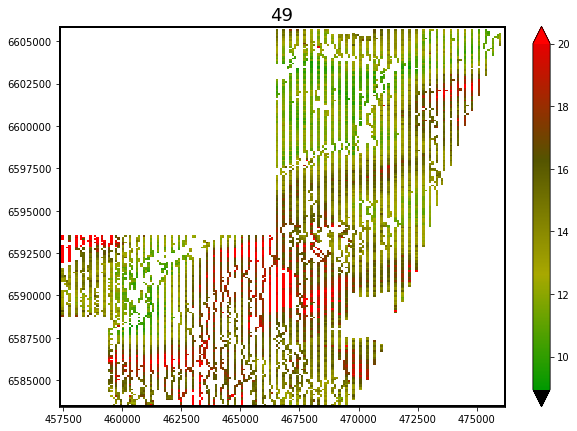

Mean value of metrics: 14.8


In [39]:
metrics = pipeline.v('metrics')
mean_metrics = metrics.evaluate('map', bin_size=100, title='49', figsize=(10, 7), save_dir=None, pad=True, max_value=20)
print('Mean value of metrics: {:.3}'.format(mean_metrics))

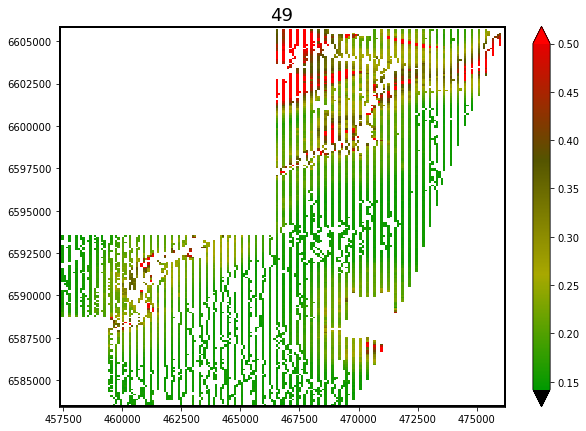

Mean value of metrics: 0.22


In [40]:
metrics = pipeline.v('metrics1')
mean_metrics = metrics.evaluate('map', bin_size=100, title='49', figsize=(10, 7), save_dir=None, pad=True, max_value=0.5)
print('Mean value of metrics: {:.3}'.format(mean_metrics))

In [18]:
sum(index_good._idf.FIRST_BREAK_TIME.values < 1)

3